In [1]:
!pip install transformers datasets scikit-learn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cu

In [2]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from datasets import Dataset
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_excel("train.xlsx")

In [5]:
df["input"] = df["text"] + " [SEP] " + df["reason"]
df = df[["input", "label"]].dropna()
df = df.sample(n=100, random_state=42)

In [6]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [8]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [9]:
def tokenize(batch):
    return tokenizer(batch["input"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [10]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

In [32]:
!pip install -U transformers --quiet


In [14]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_strategy="no",  # disables logs
    save_strategy="no",
    report_to=[] # <== THIS disables wandb
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Step,Training Loss


TrainOutput(global_step=30, training_loss=0.10206882158915202, metrics={'train_runtime': 171.9412, 'train_samples_per_second': 1.396, 'train_steps_per_second': 0.174, 'total_flos': 7948043919360.0, 'train_loss': 0.10206882158915202, 'epoch': 3.0})

In [15]:
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# Print metrics
acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")



📊 Evaluation Metrics:
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-score:  1.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


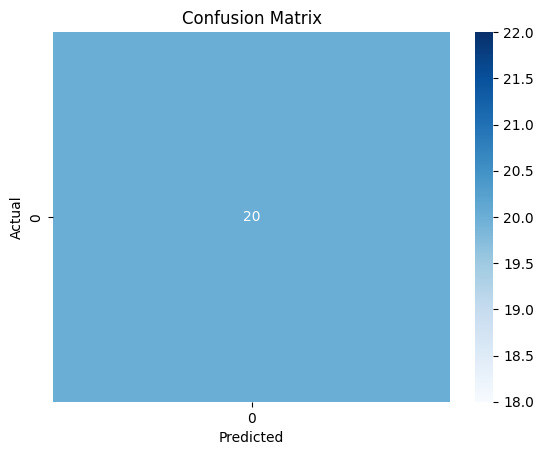

In [16]:
print(f"\n📊 Evaluation Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")

# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [22]:
def predict_alignment(text, reason):
    # Combine text and reason the same way as training
    input_text = text + " [SEP] " + reason
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True, max_length=128)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        prediction = torch.argmax(probs, dim=1).item()
        confidence = probs[0][prediction].item()

    label = "Aligned ✅" if prediction == 1 else "Not Aligned ❌"
    return label, confidence


In [23]:
# Example user input
feedback = "The course was too fast to follow."
reason = "Course pace issue"

# Get prediction
label, confidence = predict_alignment(feedback, reason)
print(f"Prediction: {label}")
print(f"Confidence: {confidence:.2f}")


Prediction: Aligned ✅
Confidence: 0.99
